In [1]:
import random
import itertools as it
from pathlib import Path

import mido
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from notepredictor import NotePredictor, MIDIDataset
from notepredictor.distributions import CensoredMixturePointyBoi

In [2]:
# data_dir = Path('/Users/victor/Downloads/lmd_full')
# files = list(data_dir.glob('**/*.mid'))

In [3]:
# try:
#     mid = mido.MidiFile(random.choice(files))
# except Exception as e:
#     print(e, e.msg)
# tempos = {m.tempo for tr in mid.tracks for m in tr if m.type=='set_tempo'}
# tuple(tempos)[0] / mid.ticks_per_beat / 1e6
# mid.tracks[1]


In [4]:
data_dir = Path('/Users/victor/data/lmd_prep')

In [5]:
batch_size = 32
batch_len = 64

ds = MIDIDataset(data_dir, batch_len)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=0)

In [6]:
%%time
batch = next(iter(dl))
batch['pitch'].shape, batch['time'].shape

CPU times: user 26.6 ms, sys: 10.4 ms, total: 36.9 ms
Wall time: 38 ms


(torch.Size([32, 64]), torch.Size([32, 64]))

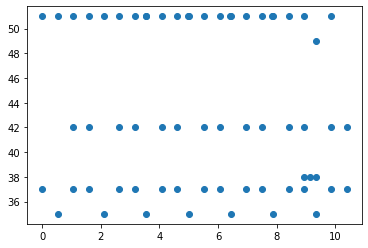

In [7]:
i = 0
plt.scatter(batch['time'][i].cumsum(0), batch['pitch'][i])

In [8]:
times = []
for item in tqdm(it.islice(ds, 1000)):
    times.extend(item['time'])

1000it [00:00, 1205.60it/s]


/Users/victor/anaconda3/envs/event-predictor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.460578125

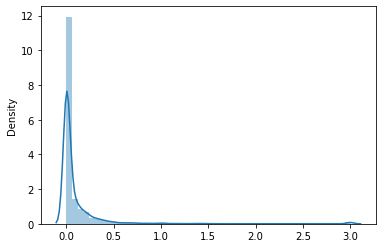

In [9]:
sns.distplot(x=np.clip(np.array(times), 0, 3))
np.mean(np.array(times)==0)

In [10]:
b = 3
n = 5
r = 0.1
lo, hi = 0, 10

bins = int((hi-lo)/r)

dist = CensoredMixturePointyBoi(n, r, lo, hi)

with torch.no_grad():
    h = torch.randn(b, n*3) + 1
    x = torch.linspace(lo,hi,bins)[...,None]
    samps = dist.sample(h, 100_000)
    probs = dist(h, x)['log_prob'].exp()

probs.sum(0)


tensor([0.9944, 0.9926, 0.9941])

/Users/victor/anaconda3/envs/event-predictor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


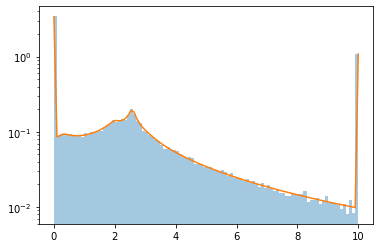

In [11]:
i = 0
sns.distplot(samps[:,i], kde=False, norm_hist=True, bins=bins)
plt.plot(x[:,0], probs[:,i]/r)
plt.yscale('log')

In [12]:
grads = []
h2 = (h[i:i+1]*2).clone().requires_grad_(True)
x = torch.linspace(lo-1,hi+1,bins*4)
for t in tqdm(x):
    h2.grad = None
    dist(h2, t[None,None])['log_prob'].backward()
    grads.append(h2.grad.detach().clone())
grads = torch.stack(grads, -1)[0]

100%|██████████| 400/400 [00:00<00:00, 506.94it/s]


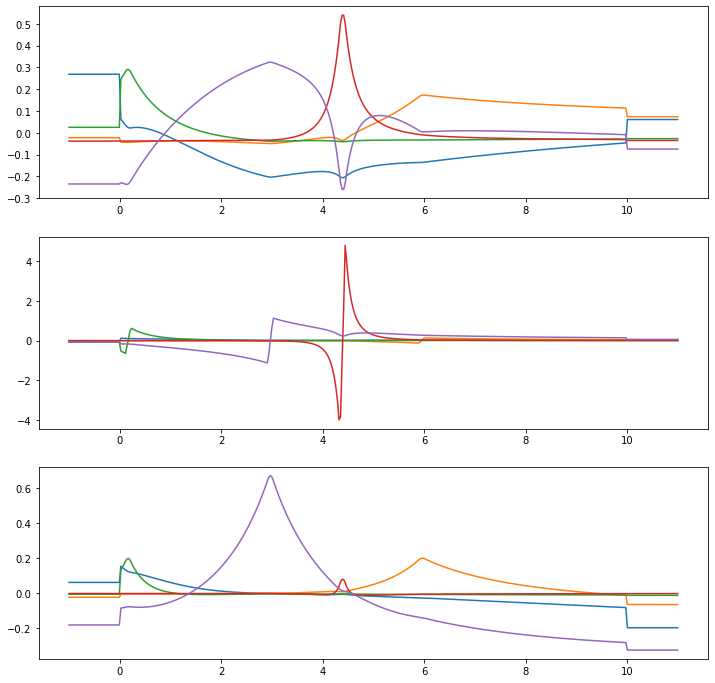

In [13]:
fig, ax = plt.subplots(3,1,figsize=(12,12))
gs = grads.chunk(3, 0)
for a, g in zip(ax, gs):
    a.plot(x, g.t())

In [14]:
net = NotePredictor(hidden_size=128, num_pitches=128, num_layers=2)
# net = PitchPredictor.from_checkpoint('/Users/victor/Downloads/0132.ckpt')

In [15]:
net.reset()

In [17]:
%%timeit
net.predict(60, 0)

1.44 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
losses = []

# train

In [22]:
# %%prun

for batch in tqdm(it.islice(dl,512)):
    # batch = torch.LongTensor([notes for notes in it.islice(gen_tracks(batch_len), batch_size)])
    opt.zero_grad()
    r = net(batch['pitch'], batch['time'])
    nll = (-r['pitch_log_probs']).mean()
    nll.backward()
    opt.step()
    losses.append(nll.item())
plt.plot(losses)

378it [01:15,  4.28it/s]

In [12]:
# torch.save(net.state_dict(), 'notes_lakh_16k.pt')

In [ ]:
%%time
acc = 0
m = 64
ds_it = iter(ds)
for _ in range(m):
    item = next(ds_it)
    pitch, time = item['pitch'], item['time']
    n = len(pitch)-1
    net.reset()
    pred = net.predict(pitch[i], time[i])
    acc += sum(pred['pitch']==pitch[i+1] for i in range(n))/n
acc/m

CPU times: user 284 ms, sys: 38.5 ms, total: 322 ms
Wall time: 394 ms


tensor(0.1121)

In [21]:
batch_size*len(losses) / len(ds.files)

0.13836201800462783

# unigram baseline

first, visualize the model's unigram probabilities:


In [ ]:
# TODO: this more more complicated with the pitch_time model

In [ ]:
# net_probs = []
# for a in range(130):
#     net.reset()
#     b = net.predict(a, sample=False)
#     net_probs.append(b)
# net_probs = torch.stack(net_probs, 0)

Text(0.5, 1.0, 'log P(b|a)')

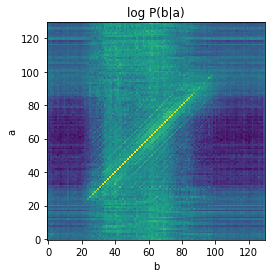

In [ ]:
# plt.imshow(net_probs.data.log(), origin='lower', interpolation='nearest')
# plt.ylabel('a')
# plt.xlabel('b')
# plt.title('log P(b|a)')

compute unigram proabilities over the data:

In [24]:
counts = torch.zeros(130,130).long()
for item in tqdm(ds):
    s = item['pitch']
    counts[s[:-1], s[1:]] += 1

100%|██████████| 118414/118414 [03:01<00:00, 652.77it/s]


Text(0.5, 1.0, 'log P(b|a)')

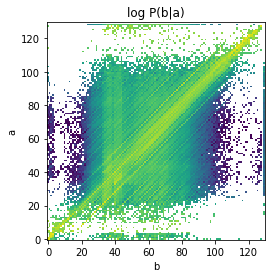

In [43]:
#P(b|a)
probs = counts / counts.sum(1,keepdims=True)
probs
plt.imshow(probs.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(b|a)')

<BarContainer object of 128 artists>

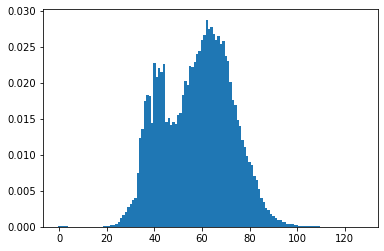

In [51]:
#ignoring start/stop tokens
marg = counts[:128].sum(1) / counts[:128].sum()
plt.bar(range(128), marg, width=1)

In [52]:
# baseline accuracy
(probs[:128, :128].max(1).values * marg).sum()

tensor(0.0723)

<BarContainer object of 130 artists>

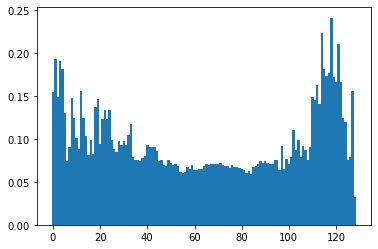

In [28]:
plt.bar(range(130), probs.max(1).values, width=1)

### bigrams

In [62]:
counts = torch.zeros(130,130,130).long()
for item in tqdm(ds):
    s = item['pitch']
    counts[s[:-2], s[1:-1], s[2:]] += 1

100%|██████████| 118414/118414 [03:03<00:00, 645.41it/s]


Text(0.5, 1.0, 'log P(c|a=60,b)')

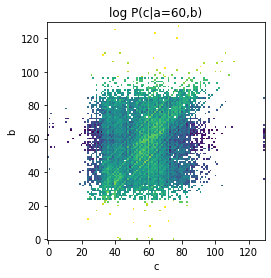

In [64]:
#P(c|a,b)
probs = counts / counts.sum(-1,keepdims=True)
plt.imshow(probs[60].log(), origin='lower', interpolation='nearest')
plt.ylabel('b')
plt.xlabel('c')
plt.title('log P(c|a=60,b)')

Text(0.5, 1.0, 'log P(a,b)')

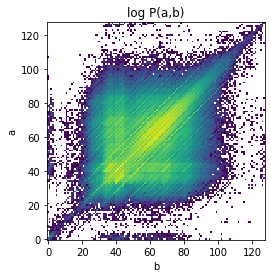

In [65]:
#ignoring start/stop tokens
marg = counts[:128, :128].sum(-1) / counts[:128, :128].sum()
plt.imshow(marg.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(a,b)')

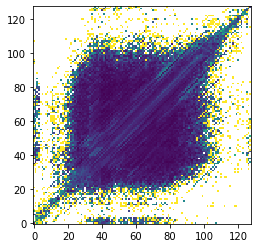

In [71]:
plt.imshow(probs[:128, :128].max(-1).values, origin='lower', interpolation='nearest')

In [74]:
# baseline accuracy
(probs[:128, :128].max(-1).values.nan_to_num(0) * marg).sum()

tensor(0.1371)